In [222]:
# ---- 超参数调参方法对比 ----
# Programmer: Dan.Q
# Date:2022.3.24

# import libraries
# 建模用
from lightgbm import LGBMClassifier

# 调参用
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from hyperopt import hp,Trials,fmin,tpe

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score  # 模型评价
from sklearn.model_selection import cross_val_score # 交叉检验
import time  # count time elapsed
import matplotlib.pyplot as plt
plt.rcParams.update({"font.family":"SimHei"})   # 处理中文乱码
plt.style.use("tableau-colorblind10")
%matplotlib inline

### 1. 研究问题

常用的超参数优化方法有三种：网格搜索、随机搜索和贝叶斯优化。
* 网格搜索 | Grid Search：输入参数的一系列可选值，使用所有参数组合来训练模型，选取表现最优的模型结果。
* 随机搜索 | Randomized Search：输入参数的可选值范围，指定参数分布类型，随机生成参数组合训练模型，选取表现最优的模型结果
* 贝叶斯优化 | Bayesian Optimization：输入参数的可选值范围，指定参数分布类型，随机生成参数组合训练模型，并根据历史训练结果生成概率模型，逐步优化参数取值

这三种调参方式的原理在官方文档和许多文章中都有很好的解释，这里不再赘述（可参照文末链接）。  
本文研究的主要问题是，通过对比参数训练耗时和最终模型效果，探讨三种调参方式的优劣和适用场景。

### 2. 模型训练
#### 2.1 基线模型

这里我们以lightGBM算法为例，看看不同数据量下，各调参法在耗时与模型效果上的表现。

数据集取自天猫复购数据，特征X为用户与商家的交互行为数据，标签y为是否复购用户。特征提取方式详见：[天猫复购预测](https://www.heywhale.com/mw/project/622da28b8a84f900178991c7)。

首先用默认参数作为基线模型，计算训练耗时与AUC分数。

In [126]:
# load data
data = pd.read_csv("data/features.csv")
data.head(1)

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,...,um1,um2,um3,um4,um5,um6,um7,um8,um9,um10
0,34176,3906,0.0,train,451,47,256,45,109,108,...,39,9,20,6,1,36.0,0.0,1.0,2.0,0.027778


In [153]:
# 生成建模用数据集，数据集大小从1万递增到10万
data_i = 10000
data_size = []
dataset_list = []

while data_i <= 100000:
    # 随机从原数据集中抽取样本
    data_tmp = data.sample(n = data_i)
    X, y = data_tmp.drop(['label',"origin"],axis=1),data_tmp['label'] 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    data_size.append(data_i)
    dataset_list.append({"X_train":X_train,
                        "X_test":X_test,
                        "y_train":y_train,
                        "y_test":y_test})
    data_i += 10000

In [156]:
# 记录基线模型的耗时与auc
time_base = []
auc_base = []

for i in range(len(data_size)):
    X_train = dataset_list[i]["X_train"]
    y_train = dataset_list[i]["y_train"]
    X_test = dataset_list[i]["X_test"]
    y_test = dataset_list[i]["y_test"]
    
    # 使用默认参数建立基线模型
    model = LGBMClassifier()
    
    start = time.time()
    model.fit(X_train,y_train)
    end = time.time()
    
    time_base.append(end - start)
    auc_lgbm  = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    auc_base.append(auc_lgbm)

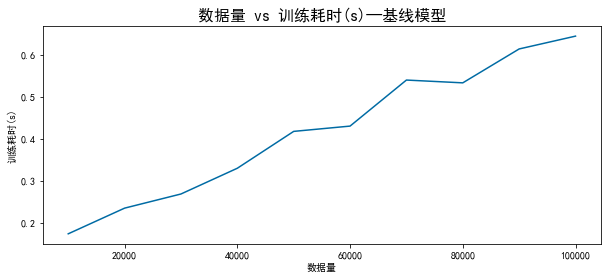

In [191]:
# plot data size v.s. time
plt.figure(figsize=(10,4))
ax = plt.plot(data_size, time_base)
plt.title("数据量 vs 训练耗时(s)—基线模型",fontsize = 16)
plt.xlabel("数据量")
plt.ylabel("训练耗时(s)")
plt.show()

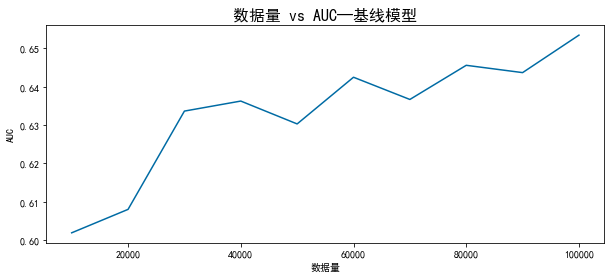

In [190]:
# plot data size v.s. auc
plt.figure(figsize=(10,4))
ax = plt.plot(data_size, auc_base)
plt.title("数据量 vs AUC—基线模型",fontsize = 16)
plt.xlabel("数据量")
plt.ylabel("AUC")
plt.show()

接下来分别统计不同数据量下，各个调参方式所需的训练时长与模型AUC分数。

#### 2.2 网格搜索 | Grid Search

In [192]:
time_grid = []
auc_grid = []
params_grid = []

for i in range(len(data_size)):
    X_train = dataset_list[i]["X_train"]
    y_train = dataset_list[i]["y_train"]
    X_test = dataset_list[i]["X_test"]
    y_test = dataset_list[i]["y_test"]
    
    model = LGBMClassifier()
    # 为保证可对比性，尽量让各调参法训练的参数组合个数一致
    params = {"learning_rate":[0.01,0.1],
              "n_estimators":[100,300,500],
              "num_leaves":[30,50],
              "min_child_samples":[10,100,1000]
             }

    grid_search = GridSearchCV(model,params,
                               cv = 3,scoring = "roc_auc")
    
    start = time.time()
    grid_search.fit(X_train,y_train)
    end = time.time()
    
    model = grid_search.best_estimator_
    
    # 记录模型训练的耗时与auc
    time_grid.append(end - start)
    auc_lgbm  = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    auc_grid.append(auc_lgbm)
    params_grid.append(grid_search.best_params_)


#### 2.3 随机搜索 | Randomized Search

In [205]:
import scipy as sp

time_rand = []
auc_rand = []
params_rand = []

for i in range(len(data_size)):
    X_train = dataset_list[i]["X_train"]
    y_train = dataset_list[i]["y_train"]
    X_test = dataset_list[i]["X_test"]
    y_test = dataset_list[i]["y_test"]
    
    model = LGBMClassifier()
    params = {"learning_rate":sp.stats.expon(scale=0.1),
              "n_estimators":sp.stats.randint(100,1000),
              "num_leaves":sp.stats.randint(10,100),
              "min_child_samples":sp.stats.randint(10,1000)
             }

    rand_search = RandomizedSearchCV(model,params,n_iter = 36,
                                     cv = 3, scoring = "roc_auc")
    
    start = time.time()
    rand_search.fit(X_train,y_train)
    end = time.time()
    
    model = rand_search.best_estimator_
    
    # 记录模型训练的耗时与auc
    time_rand.append(end - start)
    auc_lgbm  = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    auc_rand.append(auc_lgbm)
    params_rand.append(rand_search.best_params_)

#### 2.4 贝叶斯优化 | Bayesian Optimization
这里我们使用正态分布和TPE两种算法来尝试贝叶斯优化。

In [206]:
# Bayes with Gaussian Process 正态分布
time_bayes = []
auc_bayes = []
params_bayes = []

for i in range(len(data_size)):
    X_train = dataset_list[i]["X_train"]
    y_train = dataset_list[i]["y_train"]
    X_test = dataset_list[i]["X_test"]
    y_test = dataset_list[i]["y_test"]

    model = LGBMClassifier()
    params = {"learning_rate":(0.005,0.1,"log-uniform"),
              "n_estimators":(100,1000),              
              "num_leaves":(10,100),
              "min_child_samples":(10,1000)
             }

    bayes_search = BayesSearchCV(model,params,n_iter = 36,
                                 optimizer_kwargs = {'base_estimator': 'GP'},
                                 cv = 3, scoring = "roc_auc")
    
    start = time.time()
    bayes_search.fit(X_train,y_train)
    end = time.time()
    
    model = bayes_search.best_estimator_
    
    # 记录模型训练的耗时与auc
    time_bayes.append(end - start)
    auc_lgbm  = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    auc_bayes.append(auc_lgbm)
    params_bayes.append(bayes_search.best_params_)
    

In [240]:
# Bayes with TPE
time_bayes_tpe = []
auc_bayes_tpe = []
params_bayes_tpe = []

for i in range(len(data_size)):
    X_train = dataset_list[i]["X_train"]
    y_train = dataset_list[i]["y_train"]
    X_test = dataset_list[i]["X_test"]
    y_test = dataset_list[i]["y_test"]

    # objective function
    def obj_func(params):
        model = LGBMClassifier(**params)
        score = cross_val_score(model, X_train, y_train, cv=3,scoring="roc_auc").mean()
        return {"loss":-score,'status': "ok","model":model}

    # domain space
    params = {"learning_rate":hp.loguniform("learning_rate",np.log(0.005),np.log(0.1)),
                "n_estimators":hp.uniformint("n_estimators",100,1000),              
                "num_leaves":hp.uniformint("num_leaves",10,100),
                "min_child_samples":hp.uniformint("min_child_samples",10,1000)
    }

    trials = Trials()
    
    start = time.time()
    best_param = fmin(obj_func,space = params,algo=tpe.suggest, 
                      max_evals=36, trials=trials)
    model  = trials.best_trial['result']['model']
    model.fit(X_train,y_train)
    end = time.time()
    
    
    # 记录模型训练的耗时与auc
    time_bayes_tpe.append(end - start)    
    auc_lgbm = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    auc_bayes_tpe.append(auc_lgbm)
    params_bayes_tpe.append(best_param)

100%|███████████████████████████████████████████████| 36/36 [05:02<00:00,  8.41s/trial, best loss: -0.6544209957077353]


### 3. 结果讨论
绘图比较三种调参法的结果。

#### 3.1 训练耗时

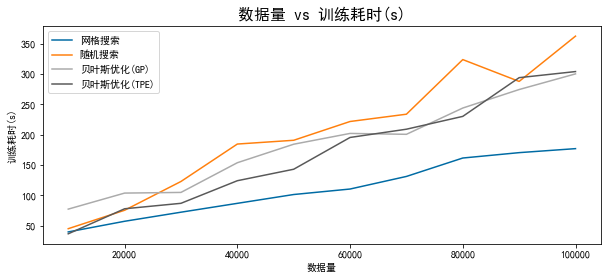

In [242]:
plt.figure(figsize=(10,4))
ax1 = plt.plot(data_size, time_grid,label = "网格搜索")
ax2 = plt.plot(data_size, time_rand,label = "随机搜索")
ax3 = plt.plot(data_size, time_bayes,label = "贝叶斯优化(GP)")
ax4 = plt.plot(data_size, time_bayes_tpe,label = "贝叶斯优化(TPE)")
plt.title("数据量 vs 训练耗时(s)",fontsize = 16)
plt.xlabel("数据量")
plt.ylabel("训练耗时(s)")
plt.legend()
plt.show()    

从以上数据可以看出，在保证训练参数组合与交叉检验次数一致的情况下，三种调参法训练耗时都随着数据量增长而变长。随机搜索和贝叶斯优化的算法因为扩展了参数取值范围，训练时长比网格搜索要长一些。  
整体来看，贝叶斯优化比随机搜索耗时更短，两种贝叶斯优化算法中，TPE比GP更快，尤其是当数据量较小的时候。

#### 3.2 模型效果

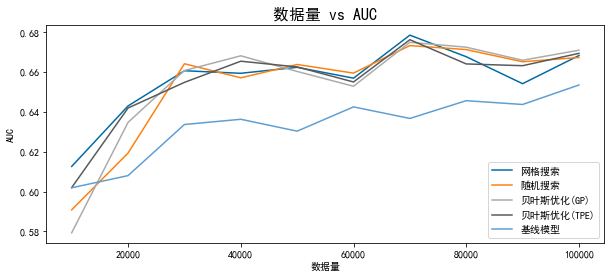

In [243]:
plt.figure(figsize=(10,4))
ax = plt.plot(data_size, auc_grid,label = "网格搜索")
ax2 = plt.plot(data_size, auc_rand,label = "随机搜索")
ax3 = plt.plot(data_size, auc_bayes,label = "贝叶斯优化(GP)")
ax4 = plt.plot(data_size, auc_bayes_tpe,label = "贝叶斯优化(TPE)")
ax5 = plt.plot(data_size, auc_base,label = "基线模型")
plt.title("数据量 vs AUC",fontsize = 16)
plt.xlabel("数据量")
plt.ylabel("AUC")
plt.legend()
plt.show()

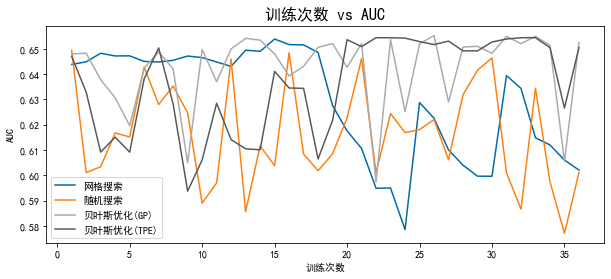

In [244]:
# n_estimators v.s. auc
grid_auc = grid_search.cv_results_["mean_test_score"]
rand_auc = rand_search.cv_results_["mean_test_score"]
bayes_auc = bayes_search.cv_results_["mean_test_score"]
bayes_auc_tpe = [-trial["result"]["loss"] for trial in trials]
n_iter = list(range(1,len(grid_auc)+1))

plt.figure(figsize=(10,4))
ax = plt.plot(n_iter, grid_auc,label = "网格搜索")
ax2 = plt.plot(n_iter, rand_auc,label = "随机搜索")
ax3 = plt.plot(n_iter, bayes_auc,label = "贝叶斯优化(GP)")
ax4 = plt.plot(n_iter, bayes_auc_tpe,label = "贝叶斯优化(TPE)")
plt.title("训练次数 vs AUC",fontsize = 16)
plt.xlabel("训练次数")
plt.ylabel("AUC")
plt.legend()
plt.show()

从模型训练结果看，几乎所有调参法的结果都要优于基线模型，且AUC分数随着样本量增加而增加，同时在样本量达到一定规模后逐渐趋平。  
当样本量较小时，网格搜索存在明显优势，可以较快得到较好的训练效果。随着样本量增大，三种调参方式训练效果逐渐趋同，贝叶斯优化的表现要更为稳定。
从训练过程看，TPE算法的收敛效果更好，在训练次数达到约20次后训练结果逐渐平稳，GP算法则是在约27次后平稳。

总结一下：
* 网格搜索 | Grid Search：相当于穷举。一般而言，当对参数取值有经验值可参考，且模型训练较快时适用，否则每增加一个参数值，所需训练的耗时都会翻倍
* 随机搜索 | Randomized Search：与网格搜索原理类似，由于参数为随机取值而非人工主观定的，当取值点覆盖不够均匀完全时，并不一定能得到比网格搜索更好的模型训练结果，尤其数据量少时偏差较大
* 贝叶斯优化 | Bayesian Optimization：从原理来说比网格搜索和随机搜索都更有效率，更适用于模型训练较慢的场景，如需要调优的参数较多、数据样本量较大、参数取值无经验值可参考等

整体来看，贝叶斯优化算法略优于另外两种，但并不能保证可以取得最好的训练结果。实际应用时，还是需要具体情况具体分析。

### 参考资料

* [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)
* [Sequential model-based optimization in Python](https://scikit-optimize.github.io/stable/)
* [A Conceptual Explanation of Bayesian Hyperparameter Optimization for Machine Learning](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
* [Hyperparameter Tuning in Python: a Complete Guide](https://neptune.ai/blog/hyperparameter-tuning-in-python-complete-guide)
* [hyperparameter_optimization_for_neural_networks](http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html)

In [2]:
!jupyter nbconvert 调参方法比较.ipynb --to html

[NbConvertApp] Converting notebook 调参方法比较.ipynb to html
[NbConvertApp] Writing 544836 bytes to 调参方法比较.html
